## Coding an LLM Architecture

In [1]:
# Configuration of the small GPT-2 model
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [2]:
import torch
import torch.nn as nn

# A Dummy GPT model class to illustrate the architecture
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

In [4]:
# Tokenize a batch consisting of two text inputs using tiktoken tokenizer
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch

[tensor([6109, 3626, 6100,  345]), tensor([6109, 1110, 6622,  257])]

In [5]:
batch = torch.stack(batch, dim=0)
batch

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

In [6]:
batch.shape

torch.Size([2, 4])

In [7]:
# Initialize a new 124-million parameter DummyGPTModel and feed it the tokenized batch

torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
logits.shape  # Should be (batch_size, seq_len, vocab_size)

torch.Size([2, 4, 50257])

In [8]:
logits

tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)

## Normalizing Activations with Layer Normalization
The main idea behind layer normalization is adjust the activations (outputs) of a neural network to have a mean of 0 and variance of 1. This adjustment speeds up the convergence to effective weights and ensures consistent and reliable training.

In [9]:
# An illustration of Layer Normalization
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
batch_example

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

In [10]:
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
out

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)

In [11]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [12]:
# Apply layer normalization to the layer outputs
out_nor = (out - mean) / torch.sqrt(var) # subtract mean and divide by std

mean = out_nor.mean(dim=-1, keepdim=True)
var = out_nor.var(dim=-1, keepdim=True)

print("Normalized Layer Output:\n", out_nor)
print("Normalized Mean:\n", mean)
print("Normalized Variance:\n", var)

Normalized Layer Output:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Normalized Mean:
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
Normalized Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [13]:
# Turn off scientific notation for better readability
torch.set_printoptions(sci_mode=False)
print("Normalized Mean:\n", mean)
print("Normalized Variance:\n", var)

Normalized Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Normalized Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [14]:
# Implementing a Layer Normalization class
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        # Compute mean and variance
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)

        # Apply layer normalization
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return norm_x * self.scale + self.shift

In [15]:
# Apply LayerNorm module to the batch input
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)
print("Layer Normalized Output:\n", out_ln)
print("Layer Normalized Mean:\n", mean)
print("Layer Normalized Variance:\n", var)

Layer Normalized Output:
 tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)
Layer Normalized Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Layer Normalized Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## Implementing a Feed Forward network with GELU activations

In [16]:
# Implementing GELU activation function
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0) / torch.pi) * (x + 0.044715 * torch.pow(x, 3))))

In [17]:
# Compare the GELU activation with ReLU

import matplotlib.pyplot as plt
import numpy as np

gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100) # Creates a tensor of 100 points between -3 and 3
x

tensor([-3.0000, -2.9394, -2.8788, -2.8182, -2.7576, -2.6970, -2.6364, -2.5758,
        -2.5152, -2.4545, -2.3939, -2.3333, -2.2727, -2.2121, -2.1515, -2.0909,
        -2.0303, -1.9697, -1.9091, -1.8485, -1.7879, -1.7273, -1.6667, -1.6061,
        -1.5455, -1.4848, -1.4242, -1.3636, -1.3030, -1.2424, -1.1818, -1.1212,
        -1.0606, -1.0000, -0.9394, -0.8788, -0.8182, -0.7576, -0.6970, -0.6364,
        -0.5758, -0.5152, -0.4545, -0.3939, -0.3333, -0.2727, -0.2121, -0.1515,
        -0.0909, -0.0303,  0.0303,  0.0909,  0.1515,  0.2121,  0.2727,  0.3333,
         0.3939,  0.4545,  0.5152,  0.5758,  0.6364,  0.6970,  0.7576,  0.8182,
         0.8788,  0.9394,  1.0000,  1.0606,  1.1212,  1.1818,  1.2424,  1.3030,
         1.3636,  1.4242,  1.4848,  1.5455,  1.6061,  1.6667,  1.7273,  1.7879,
         1.8485,  1.9091,  1.9697,  2.0303,  2.0909,  2.1515,  2.2121,  2.2727,
         2.3333,  2.3939,  2.4545,  2.5152,  2.5758,  2.6364,  2.6970,  2.7576,
         2.8182,  2.8788,  2.9394,  3.00

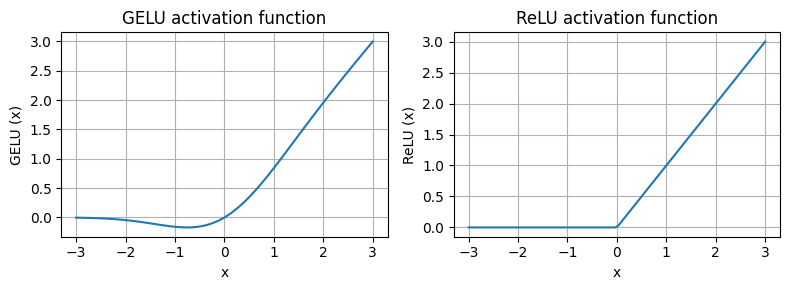

In [18]:
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ['GELU', 'ReLU']), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label} (x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
# Implementing a small Feed Forward network with GELU function
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], cfg['emb_dim'] * 4), # Expands the dimension by a factor of 4
            GELU(),
            nn.Linear(cfg['emb_dim'] * 4, cfg['emb_dim']) # Projects back to the original dimension
        )
    def forward(self, x):
        return self.layers(x)

In [20]:
ffn = FeedForward(GPT_CONFIG_124M) # Takes emb_dim from the configuration which is 768
x = torch.rand(2, 3, GPT_CONFIG_124M['emb_dim'])  # Sample input with batch size 2 and sequence length 3. Each sequence has 768 features

# Forward pass through the Feed Forward network
out = ffn(x)
out.shape  # Should be (batch_size, seq_len, emb_dim)

torch.Size([2, 3, 768])

## Adding Shortcut Connections to Neural Network
Shortcut connections also known as skip connections to mitigate the challenge of vanishing gradients during back propagation in neural networks

In [21]:
# Implementing a Neural Network with Shortcut Connections
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut

        # Create 5 layers with GELU activation
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[i], layer_sizes[i + 1]), GELU())
            for i in range(len(layer_sizes) - 1)
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [22]:
# Initialize NN without shortcut connections
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

In [23]:
# Implementing a function that computes the gradients in the model's backward pass

def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])  # Dummy target for the sake of computing gradients

    loss = nn.MSELoss()(output, target)

    loss.backward()  # Compute gradients

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [24]:
# Print gradients for the model without shortcut connections
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


In [25]:
# Creating a model with shortcut connections
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
# Print gradients for the model with shortcut connections
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


## Connecting Attention and Linear Layers in a Transformer block

In [26]:
# Implementing the Transformer block component of GPT
from utils.masked_multi_head_attentions import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiHeadAttention(
            d_in=cfg['emb_dim'],
            d_out=cfg['emb_dim'],
            context_length=cfg['context_length'],
            num_heads=cfg['n_heads'],
            dropout=cfg['drop_rate'],
            qkv_bias=cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)
        x = self.drop_shortcut(x) + shortcut  # Add shortcut connection

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x) + shortcut  # Add another shortcut connection
        return x

In [27]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
out = block(x)

print("Output shape of TransformerBlock:", out.shape)
print("Output of TransformerBlock:\n", out)

Output shape of TransformerBlock: torch.Size([2, 4, 768])
Output of TransformerBlock:
 tensor([[[ 0.1648,  0.4002, -0.0749,  ...,  1.2646,  0.3324,  0.7243],
         [ 0.0293,  0.0498,  0.2529,  ...,  0.4698,  0.1281,  0.9749],
         [ 0.5532,  0.5788, -0.0310,  ...,  1.1544,  0.3947,  0.7600],
         [ 0.1631,  0.7128,  0.7271,  ...,  0.3312,  0.5730,  0.9258]],

        [[ 0.1787,  1.1682,  0.5810,  ...,  0.1828,  0.0073, -0.5603],
         [-0.2920,  0.6318,  0.2002,  ...,  0.3218,  0.4670, -0.0383],
         [ 0.9275,  0.4203,  0.3183,  ...,  0.3771,  0.7190, -0.1205],
         [ 0.6035,  0.5767,  0.3411,  ...,  1.3798,  1.2683,  0.3916]]],
       grad_fn=<AddBackward0>)


## Coding the GPT model
Replacing DummyTransformerBlock and DummyLayerNorm placeholders in DummyGPTModel with their real implementation

In [28]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )

        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [29]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("Output shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [30]:
# Inspect model parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [31]:
# Check shapes of token embedding layer and linear output layer
tok_emb_shape = model.tok_emb.weight.shape
out_head_shape = model.out_head.weight.shape

print("Token embedding layer shape:", tok_emb_shape)
print("Linear output layer shape:", out_head_shape)

Token embedding layer shape: torch.Size([50257, 768])
Linear output layer shape: torch.Size([50257, 768])


In [32]:
# Check linear output layer parameter count
out_head_params = sum(p.numel() for p in model.out_head.parameters())
print(f"Linear output layer parameters: {out_head_params:,}")

Linear output layer parameters: 38,597,376


In [33]:
# Now remove the output layer parameters from total parameters of the model
total_params_gpt2 = total_params - out_head_params
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [34]:
# Check number of parameters in the feedforward module and the multi-head attention module
ffn_params = sum(p.numel() for p in model.trf_blocks[0].ff.parameters())
attn_params = sum(p.numel() for p in model.trf_blocks[0].attn.parameters())

print(f"Feedforward module parameters: {ffn_params:,}")
print(f"Multi-head attention module parameters: {attn_params:,}")

Feedforward module parameters: 4,722,432
Multi-head attention module parameters: 2,360,064


In [35]:
# Calculate the memory requirement of our 163 million parameter GPTModel
total_size_bytes = total_params * 4  # Each float32 parameter takes 4 bytes
total_size_mb = total_size_bytes / (1024 ** 2)  # Convert bytes to megabytes
print(f"Total memory requirement: {total_size_mb:.2f} MB")

Total memory requirement: 621.83 MB


### Initializing larger GPT models
Previously we initialized 124-million-parameter GPT model, which is known as `GPT-2 small`

Now we will use the same `GPTModel` class to initialize following models -
1. GPT-2 medium: 1024-dimentional embeddings, 24 transformer block, 16 multi-head attention heads
2. GPT-2 large: 1280-dimentional embeddings, 36 transformer block, 20 multi-head attention heads
3. GPT-2 XL: 1600-dimentional embeddings, 48 transformer block, 25 multi-head attention heads

Refer original GPT-2 paper https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf

In [37]:
# GPT-2 medium
GPT_CONFIG_medium = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 1024,
    "n_heads": 16,
    "n_layers": 24,
    "drop_rate": 0.1,
    "qkv_bias": False
}

gpt2_medium = GPTModel(GPT_CONFIG_medium)
gpt2_medium_parameters = sum(p.numel() for p in gpt2_medium.parameters())
print(f"Number of parameters in GPT-2 medium: {gpt2_medium_parameters:,}")

Number of parameters in GPT-2 medium: 406,212,608


In [38]:
# GPT-2 large
GPT_CONFIG_large = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 1280,
    "n_heads": 20,
    "n_layers": 36,
    "drop_rate": 0.1,
    "qkv_bias": False
}

gpt2_large = GPTModel(GPT_CONFIG_large)
gpt2_large_parameters = sum(p.numel() for p in gpt2_large.parameters())
print(f"Number of parameters in GPT-2 large: {gpt2_large_parameters:,}")

Number of parameters in GPT-2 large: 838,220,800


In [39]:
# GPT-2 XL
GPT_CONFIG_XL = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 1600,
    "n_heads": 25,
    "n_layers": 48,
    "drop_rate": 0.1,
    "qkv_bias": False
}

gpt2_xl = GPTModel(GPT_CONFIG_XL)
gpt2_xl_parameters = sum(p.numel() for p in gpt2_xl.parameters())
print(f"Number of parameters in GPT-2 XL: {gpt2_xl_parameters:,}")

Number of parameters in GPT-2 XL: 1,637,792,000


In [40]:
# Calculate memory requirements for GPT-2 XL
total_size_bytes_xl = gpt2_xl_parameters * 4  # Each float32 parameter takes 4 bytes
total_size_mb_xl = total_size_bytes_xl / (1024 ** 2)  # Convert bytes to megabytes
print(f"Total memory requirement for GPT-2 XL: {total_size_mb_xl:.2f} MB")

Total memory requirement for GPT-2 XL: 6247.68 MB


## Generating Text

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # Keep only the last context_size tokens

        with torch.no_grad(): # Disable gradient calculation because that is just inefficient for this purpose
            logits = model(idx_cond)

        # Get the last token's logits
        logits = logits[:, -1, :]  # Shape: (batch_size, vocab_size). Last row.
        probs = torch.softmax(logits, dim=-1)  # Convert logits to probabilities
        idx_next = torch.argmax(probs, dim=-1, keepdim=True)  # Get the index of the most probable token

        # Append the predicted token to the input sequence
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [42]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("Encoded start context:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # Add batch dimension
print("Encoded tensor shape:", encoded_tensor.shape)

Encoded start context: [15496, 11, 314, 716]
Encoded tensor shape: torch.Size([1, 4])


In [43]:
model.eval()  # Set the model to evaluation mode. This disables dropout and other training-specific behaviors
out = generate_text_simple(model, encoded_tensor, max_new_tokens=6, context_size=GPT_CONFIG_124M['context_length'])

print("Outout:", out)
print("Output length:", len(out[0]))

Outout: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [44]:
# Decode the generated tokens back to text
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print("Decoded text:", decoded_text)

Decoded text: Hello, I am Featureiman Byeswickattribute argue


Model output is gibberish because it is not trained yet.